In [1]:
import os
import os.path as osp
import sys
sys.path.insert(0, osp.dirname(osp.abspath('.')))

In [2]:
import torch

from data.dataset import YOLODataset, PASCAL_CLASSES
from data.transform import get_yolo_transform

from utils.convert import cells_to_bboxes
from utils.cleanup import non_max_suppression as nms
from utils.display import plot_image

%load_ext autoreload
%autoreload 2

## Hyperparameters

In [17]:
CSV_PATH = "../download/PASCAL_VOC/test.csv"
IMG_DIR = "../download/PASCAL_VOC/images/"
LABEL_DIR = "../download/PASCAL_VOC/labels/"

In [18]:
IMG_SIZE = 416
SCALES = [13, 26, 52]
ANCHORS = [
    [(0.28, 0.22), (0.38, 0.48), (0.9, 0.78)],
    [(0.07, 0.15), (0.15, 0.11), (0.14, 0.29)],
    [(0.02, 0.03), (0.04, 0.07), (0.08, 0.06)],
] # (3, 3, 2)

## Dataset

In [19]:
transform = get_yolo_transform(img_size=IMG_SIZE, mode='test')
dataset = YOLODataset(csv_file=CSV_PATH,
                      img_dir=IMG_DIR,
                      label_dir=LABEL_DIR,
                      anchors=ANCHORS,
                      transform=transform)

In [26]:
img, targets = dataset[2]

In [27]:
scaled_anchors = torch.tensor(ANCHORS)*torch.tensor(SCALES).unsqueeze(1).unsqueeze(1).repeat(1, 3, 2)

bboxes = []
for scale_idx, scale in enumerate(SCALES):
    targets_in_scale = targets[scale_idx]
    bboxes += cells_to_bboxes(targets_in_scale.unsqueeze(0),
                              scale=scale,
                              anchors=scaled_anchors[scale_idx],
                              is_preds=False)[0]

bboxes = nms(bboxes,
             iou_threshold=0.99,
             prob_threshold=0.7,
             classes=[ i for i in range(20) ],
             box_format="xywh")

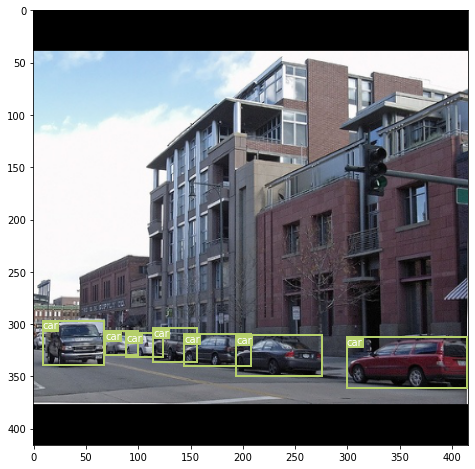

In [29]:
plot_image(img.permute(1, 2, 0).to("cpu"), bboxes, PASCAL_CLASSES)